In [3]:
from facenet import MTCNN, InceptionResnetV1
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
import torch

In [4]:
mtcnn_model = MTCNN(device = 'cpu', margin = 0)

In [5]:
def plot_box_and_label(image, lw = 1, box = None, label= None, color=(128, 128, 128), txt_color=(255, 255, 255), landmark = None):
    # Add one xyxy box to image with label
    if box is not None:
        p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
        cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
        
    if landmark is not None:
        count = 0
        for p in landmark:
            p = np.array(p, dtype = np.uint16)
            cv2.circle(image, p, 5, (255, 0, 0), -1)
    
    if label is not None:
        tf = max(lw - 1, 1)  # font thickness
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
        outside = p1[1] - h - 3 >= 0  # label fits outside box
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(image, label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2), 0, lw / 3, txt_color,
                    thickness=tf, lineType=cv2.LINE_AA)
    return image

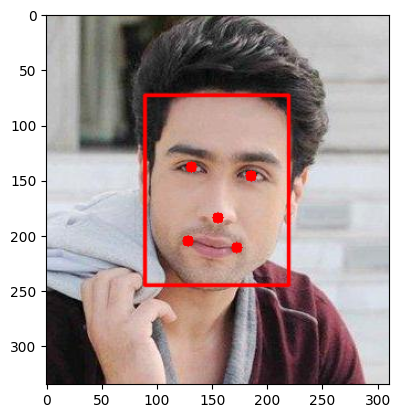

In [6]:
img = Image.open("D:\\face-recognition\\vggface_test\\n000078\\train\\0045_01.jpg").convert("RGB")

img = np.array(img)

face, box, landmark = mtcnn_model(img, return_landmarks = True)

img = plot_box_and_label(img, lw = 2, box = box[0], label = None, color = (255, 0, 0), landmark = landmark[0])

plt.imshow(img)

In [15]:
left_eye = landmark[0][0]
right_eye = landmark[0][1]

In [16]:
import math 
rad = math.atan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0])
angle = math.degrees(rad)

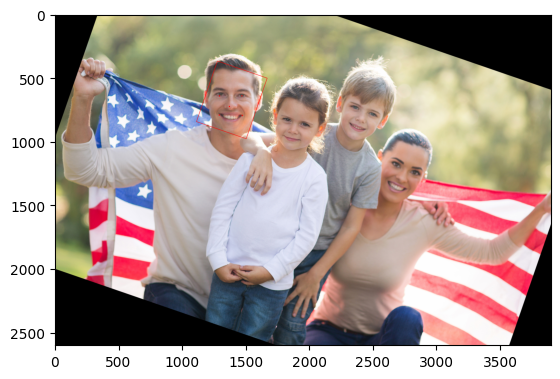

In [17]:
rotation_matrix = cv2.getRotationMatrix2D((img.shape[1] // 2, img.shape[0] // 2), angle, 1)
rotated_image = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
plt.imshow(rotated_image)

In [18]:
def rotation_matrix(angle, image_width, image_height):
    matrix = cv2.getRotationMatrix2D((image_width//2, image_height//2), angle, 1)
    return matrix

def rotate_box(x1, y1, x2, y2, matrix, image_width, image_height):
    # Chuyển thành tâm và kích thước
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2
    size = (x2 - x1, y2 - y1)

    # Áp dụng ma trận xoay cho tâm và kích thước
    
    rotated_center = np.dot(matrix, np.array([center_x, center_y, 1]))

    # Chuyển trở lại từ tâm và kích thước thành (x1, y1, x2, y2)
    rotated_x1 = rotated_center[0] - size[0] // 2
    rotated_y1 = rotated_center[1] - size[1] // 2
    rotated_x2 = rotated_center[0] + size[0] / 2
    rotated_y2 = rotated_center[1] + size[1] / 2

    # Kiểm tra xem có vượt quá biên hình ảnh không
    rotated_x1 = max(0, rotated_x1)
    rotated_y1 = max(0, rotated_y1)
    rotated_x2 = min(image_width, rotated_x2)
    rotated_y2 = min(image_height, rotated_y2)

    return rotated_x1, rotated_y1, rotated_x2, rotated_y2

def rotate_point(x, y, matrix):
    new_point = np.dot(matrix, np.array([x, y, 1]))
    
    return new_point

In [19]:

matrix = rotation_matrix(angle, img.shape[1], img.shape[0])

new_box = rotate_box(*box[0], matrix, img.shape[1], img.shape[0])

new_landmark = []

for p in landmark[0]:
    new_p = rotate_point(*p, matrix)
    new_landmark.append(new_p)
    

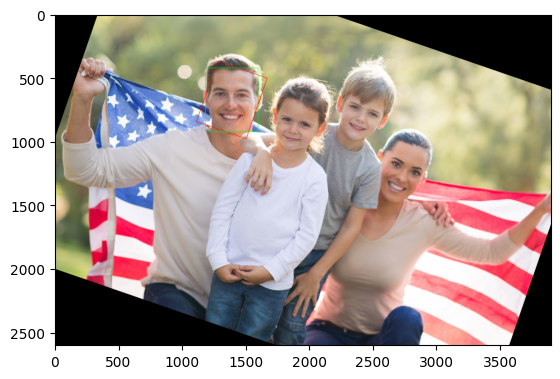

In [20]:

rotated_image = plot_box_and_label(rotated_image, lw = 2, box = new_box, label = None, color = (0, 255, 0), landmark = new_landmark)

plt.imshow(rotated_image)

In [21]:
rotated_right_eye = new_landmark[1]

padding = (new_box[3] - new_box[1])/160*15

eye_box = [new_box[0], new_box[1], new_box[2], rotated_right_eye[1] + padding]

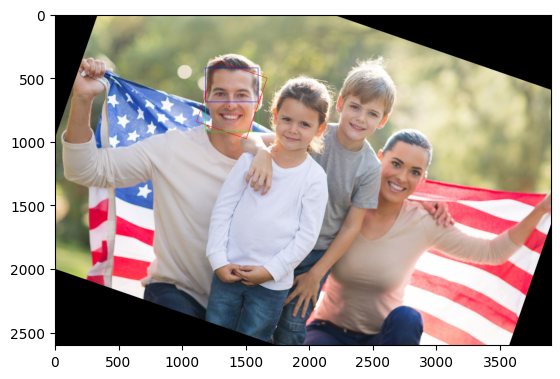

In [22]:

rotated_image = plot_box_and_label(rotated_image, lw = 2, box = eye_box, label = None, color = (0, 0, 255))

plt.imshow(rotated_image)

In [11]:
from mtcnn_ort import MTCNN
import cv2
import time
from tqdm import tqdm

detector = MTCNN()
test_pic = "images/1.jpg"

image = cv2.cvtColor(cv2.imread(test_pic), cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (640, 480))

start_time = time.time()

for i in tqdm(range(100), desc = "", ncols = 100):
    result = detector.detect_faces(image)
    
end_time = time.time()

print((end_time - start_time)*1000)

100%|█████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.63it/s]

8606.872081756592


In [2]:

import os
from facenet import *
import torch
from detect import *
from PIL import Image
import numpy as np
import shutil
from tqdm import tqdm

dir = "VGG_face_image_test"
new_dir = "vggface_test"

count_user = 0

for user_id in tqdm(os.listdir(dir), desc = "Processing"):

    count_user += 1

    new_user_dir_path = os.path.join(new_dir, user_id)
    if not os.path.exists(new_user_dir_path):
        os.mkdir(new_user_dir_path)

    train_folder = os.path.join(new_user_dir_path, "train")
    val_folder = os.path.join(new_user_dir_path, "val")

    if not os.path.exists(train_folder):
        os.mkdir(train_folder)

    if not os.path.exists(val_folder):
        os.mkdir(val_folder)

    count = 0

    for filename in os.listdir(os.path.join(dir, user_id)):

        file_path = os.path.join(dir, user_id, filename)

        shutil.move(file_path, train_folder)
        count += 1
        if count == 100:
            break
        


Processing: 100%|██████████| 500/500 [00:36<00:00, 13.66it/s]
